# CIL-ESRF pipeline

This notebook contains example scripts for loading, processing, reconstructing and visualising tomography data collected at ESRF beamlines. The steps are designed to be adaptable and configurable for different datasets.

##### Load dependencies

The pipeline makes use of CIL and other packages and some new code saved in the scripts folder. You will need to run the code inside a conda environment created with:

```
conda create --name cil -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=24.1.0 astra-toolbox=*=cuda* tigre ccpi-regulariser ipywidgets h5py hdf5plugin al
gotom
conda activate cil
pip install nabu
```

In [1]:
# CIL methods
from cil.framework import AcquisitionData, DataContainer
from cil.utilities.display import show2D
from cil.utilities.jupyter import islicer
from cil.io.utilities import HDF5_utilities
from cil.io import TIFFWriter
from cil.processors import Normaliser, RingRemover, Slicer, TransmissionAbsorptionConverter, CentreOfRotationCorrector, PaganinProcessor
from cil.recon import FBP
# Additional packages
import numpy as np # conda install numpy
import matplotlib.pyplot as plt # conda install matplotlib
import algotom.prep.removal as rem # conda install -c conda-forge algotom
from nabu.processing.unsharp import UnsharpMask # pip install nabu
import hdf5plugin # conda install -c conda-forge hdf5plugin
# Custom methods
from scripts.Custom_DataReaders import ID15_DataReader
from scripts.FluxNormaliser import FluxNormaliser
from scripts.WeightDuplicateAngles import WeightDuplicateAngles

##### Load the data

Read the data using the custom `ID15_Reader()`, to set up the reader for different experiments or beamlines, use the explore_data.ipynb notebook to configure a generic `HDF5_ParallelDataReader()`

In [2]:
filename='/mnt/share/ESRF/test_data/PC811_1000cycles_absct_final_0001.h5'
reader = ID15_DataReader(file_name=filename,
                         dataset_path=('1.1/measurement/pcoedgehs/',
                                        '4.1/measurement/pcoedgehs/'))
data = reader.read()

Use `islicer()` to visualise the data

In [3]:
islicer(data)

##### Normalise

First normalise by flux using the beam monitor in the data file and the CIL `FluxNormaliser()` method


In [4]:
data_before = data.copy()
beam_current = np.concatenate((HDF5_utilities.read(filename, '1.1/instrument/fpico2/data/'),
                HDF5_utilities.read(filename, '4.1/instrument/fpico2/data/')))
data = FluxNormaliser(flux=beam_current, target='mean')(data_before)

Next normalise the data using the flat and dark scans (we already loaded these using the data reader) and the CIL `Normaliser()` method

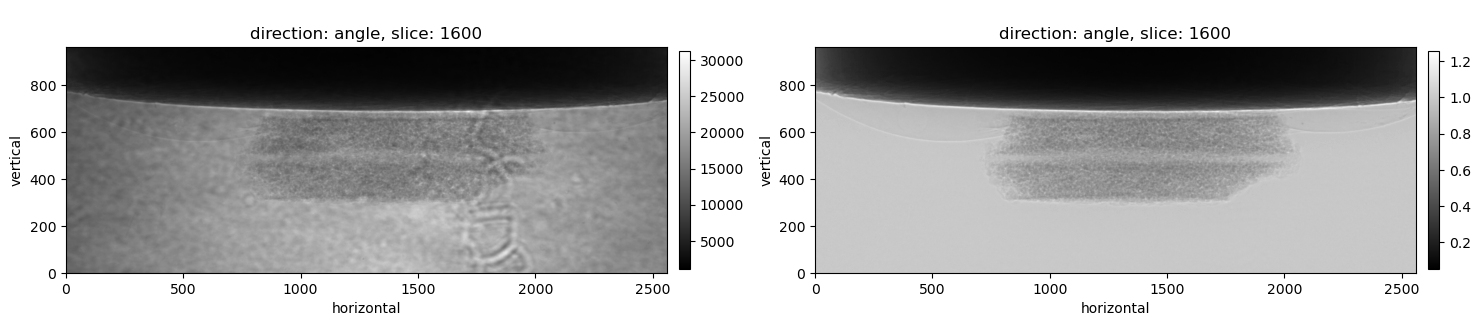

In [5]:
processor = Normaliser(flat_field=np.mean(reader.flatfield.array, axis = 0), dark_field=np.mean(reader.darkfield.array, axis = 0))
processor.set_input(data)
data = processor.get_output()

show2D([data_before, data])

Also look at a vertical slice of the data to compare the sinograms

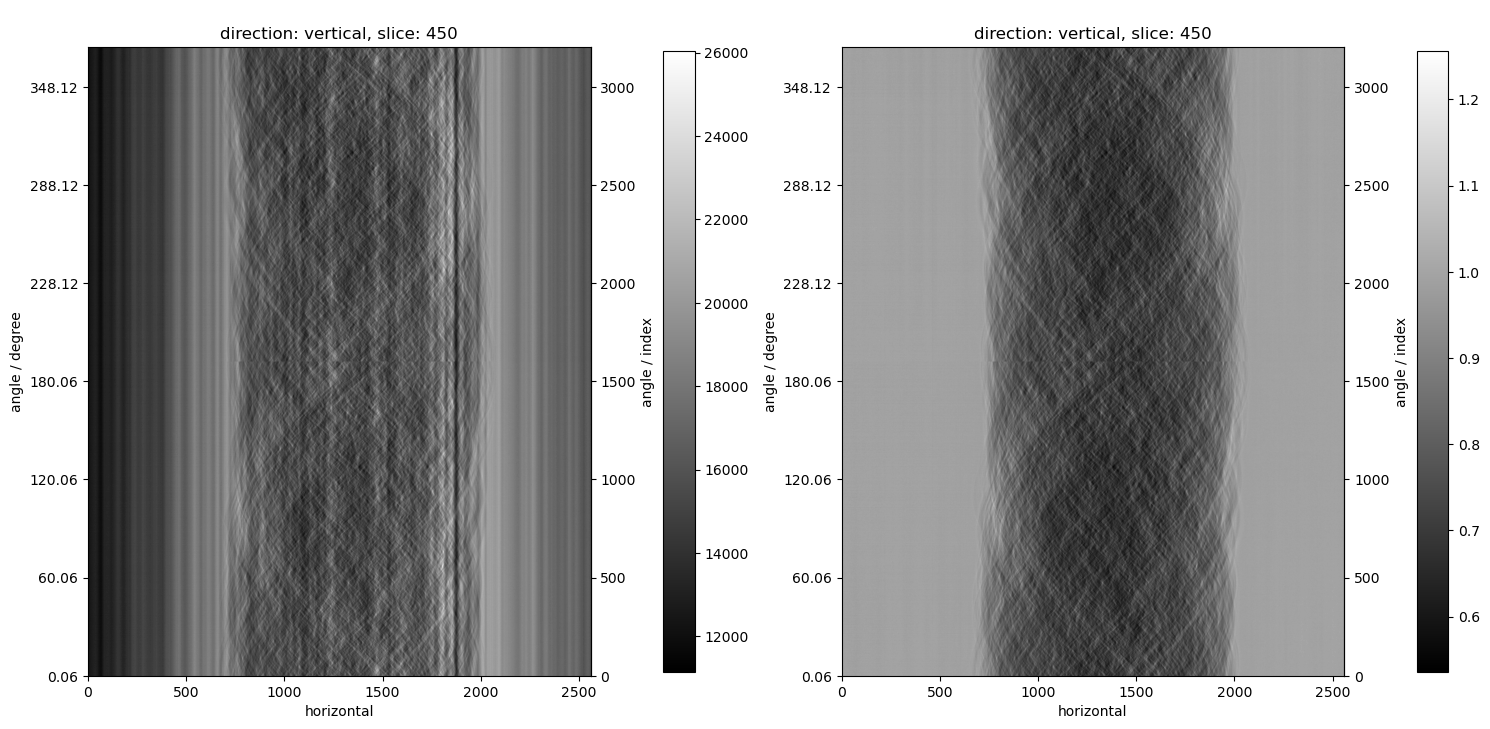

In [6]:
show2D([data_before, data], slice_list=('vertical',450))

##### Get a vertical slice of the data

In [7]:
vertical_slice = 450
data_slice = data.get_slice(vertical=vertical_slice)


##### Transmission to absorption 

Use the CIL `TransmissionAbsorptionConverter()`. If there are negative numbers in the data, specify a low value in `min_intensity` to clip these values before calculating $-log()$

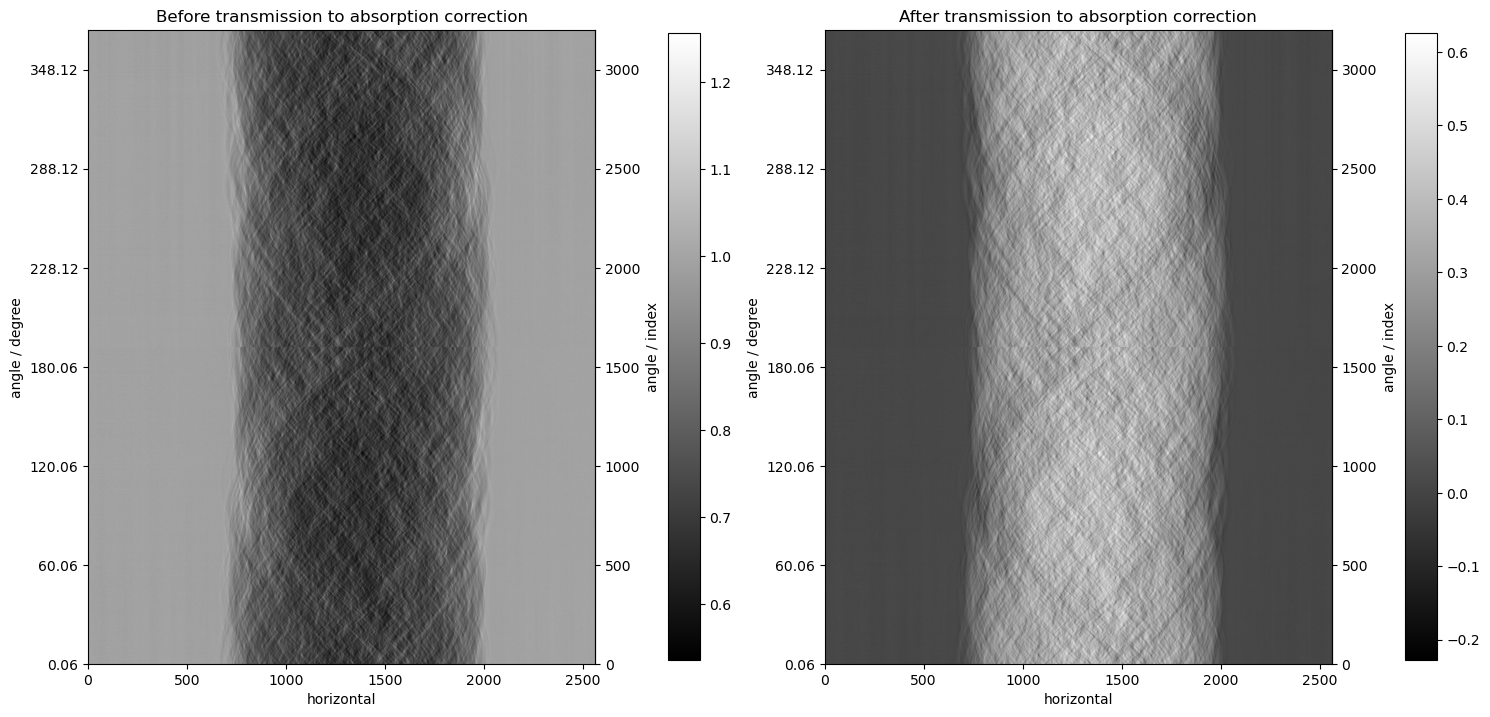

In [8]:
data_before = data_slice.copy()
data_slice = TransmissionAbsorptionConverter(min_intensity=0.001)(data_slice)
show2D([data_before, data_slice], ['Before transmission to absorption correction','After transmission to absorption correction'])


##### Filtered back projection

Next we use the CIL filtered back projection to check the reconstruction. By default this uses a Ram-Lak filter but can be configured to use different filter types.

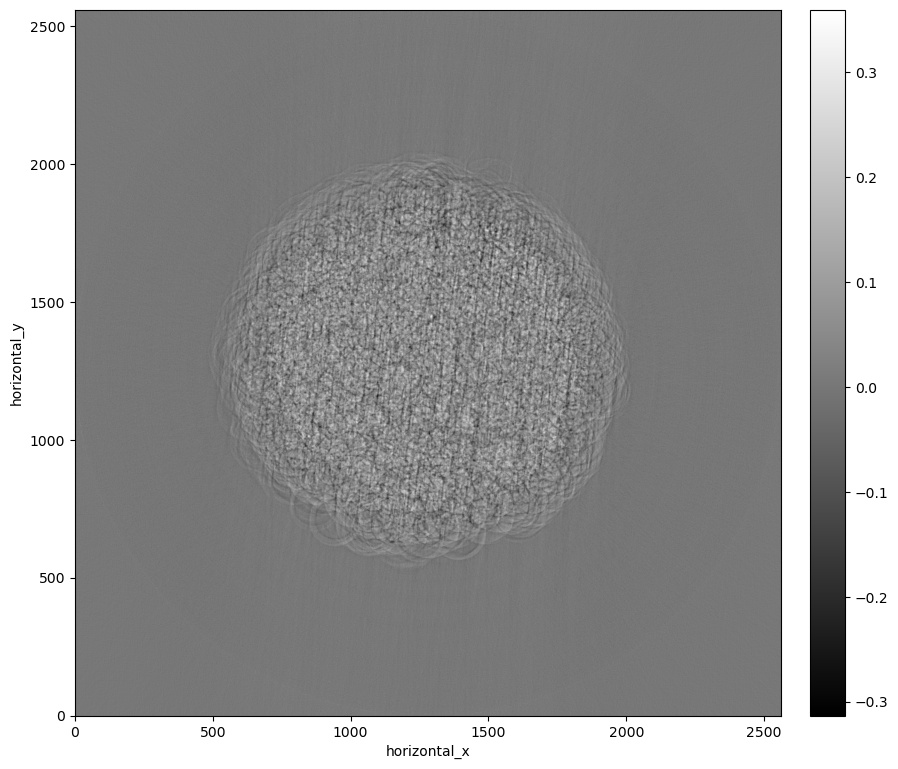

In [9]:
reco_before = FBP(data_slice).run(verbose=False)
show2D(reco_before)

##### Centre of rotation correction

If the data has projections which are 180 degrees apart, use the CIL `CentreOfRotationCorrector.xcorrelation()` processor to find the centre of rotation offset automatically.

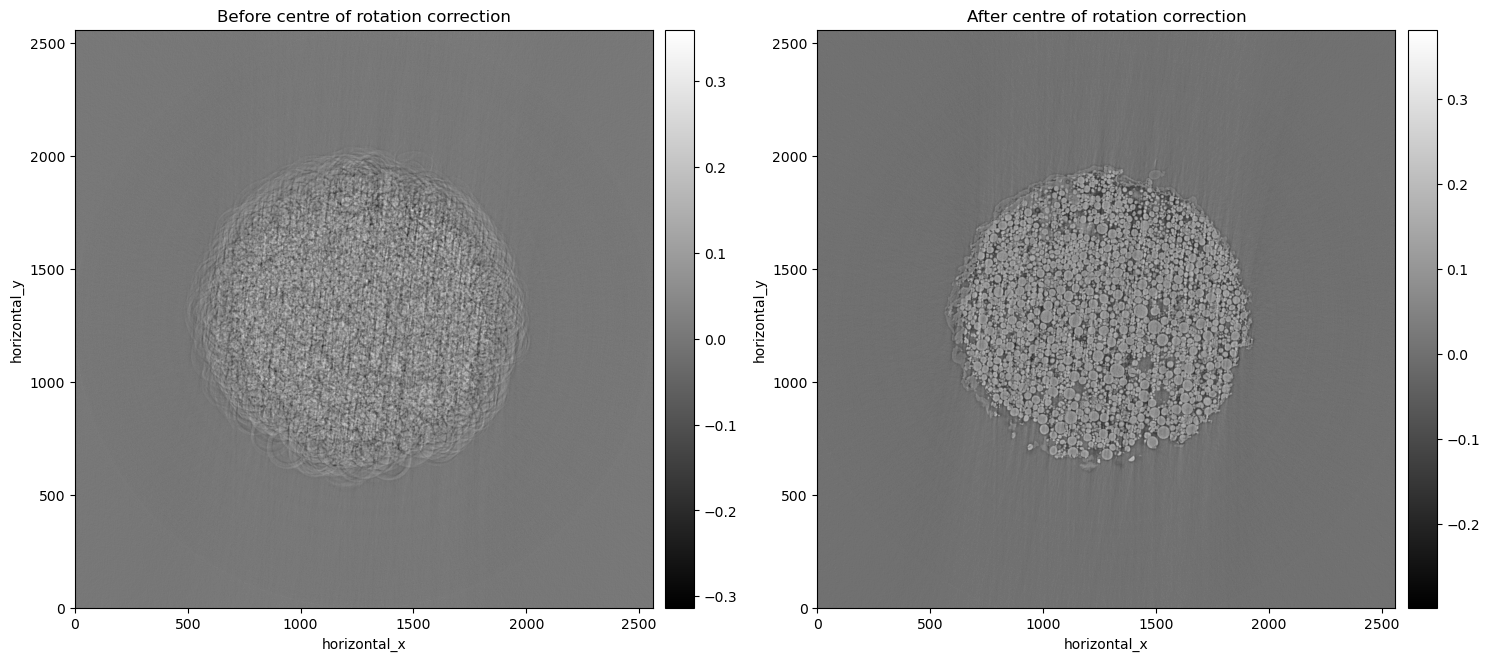

In [10]:
data_before = data_slice.copy()
data_slice = CentreOfRotationCorrector.xcorrelation()(data_slice)
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before, reco],
['Before centre of rotation correction','After centre of rotation correction'])

Print the geometry to see the rotation axis has been changed

In [11]:
print(data_before.geometry.config.system.rotation_axis.position)
print(data_slice.geometry.config.system.rotation_axis.position)

[0. 0.]
[0.544635 0.      ]


Alternatively manually enter a pixel offset. This could be extracted from the dataset metadata as a starting point

Get the positioner offset, for ID15 this is `hry`


In [12]:
# offset_rotation = HDF5_utilities.read(filename, '/1.1/instrument/positioners/idx')
# offset_rotation = offset_rotation/1000 # convert to m
# print(offset_rotation)

offset = HDF5_utilities.read(filename, '/1.1/instrument/positioners/hry')
offset = offset/1000 # convert to m
print(offset)


[1.4210855e-17 1.4210855e-17 1.4210855e-17 ... 1.4210855e-17 1.4210855e-17
 1.4210855e-17]


Get the pixel size, for ID15 this is `x_pixel_size` OR manually enter a pixel size

In [13]:
# x_pixel_size = HDF5_utilities.read(filename, '/1.1/instrument/pcoedgehs/x_pixel_size')
x_pixel_size = 0.35e-6 # units m
print(x_pixel_size)


3.5e-07


Calculate and apply the pixel offset

In [14]:
pixel_offset = (((offset)/(x_pixel_size)))
print(pixel_offset)

data_slice.geometry.set_centre_of_rotation(np.mean(pixel_offset), distance_units='pixels')

[4.0602445e-11 4.0602445e-11 4.0602445e-11 ... 4.0602445e-11 4.0602445e-11
 4.0602445e-11]


We can loop through different pixel offsets and view the reconstructions using islicer and choose the offset where rotation artefacts are minimised

In [15]:
array_list = []
pixel_offsets = [80., 81, 82, 83, 84, 85, 86]
for p in pixel_offsets:
    data_slice = data_before.copy()
    data_slice.geometry.set_centre_of_rotation(p, distance_units='pixels')
    reco = FBP(data_slice).run(verbose=False)
    array_list.append(reco.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Centre of rotation offset']) + reco.geometry.dimension_labels)
islicer(DC)


In [16]:
best_slice_index = 3
data_slice.geometry.set_centre_of_rotation(pixel_offsets[best_slice_index], distance_units='pixels')

##### Crop the data

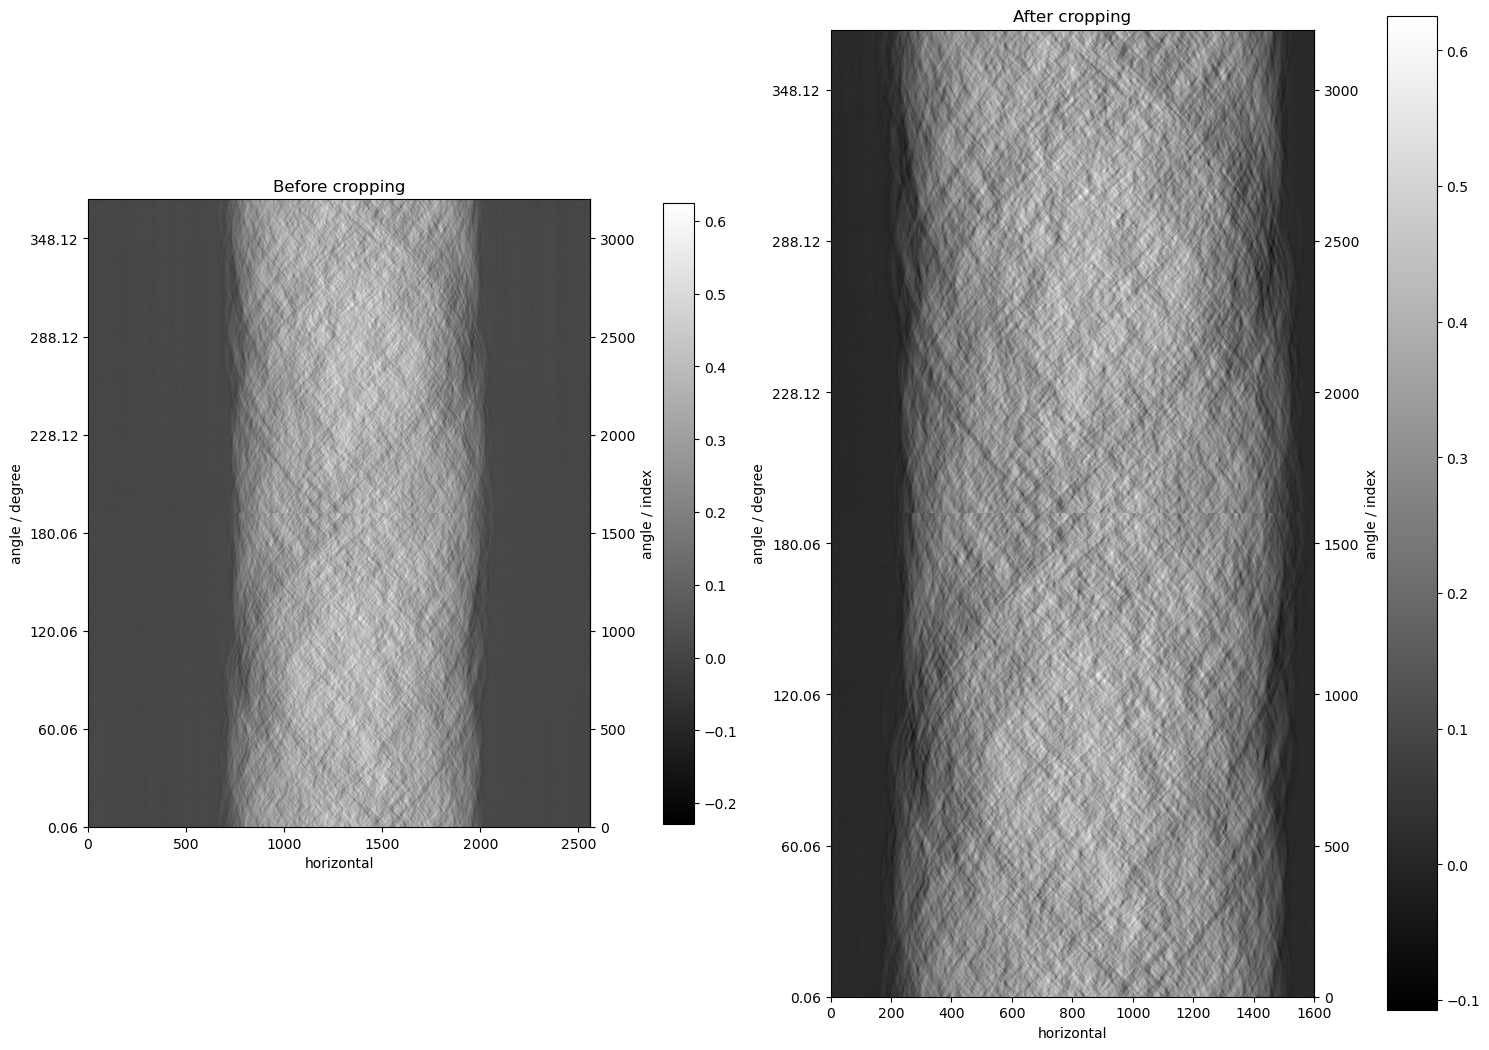

In [17]:
data_before = data_slice.copy()
data_slice = Slicer(roi = {'horizontal':(500,2100,1)})(data_slice)
show2D([data_before, data_slice], title=['Before cropping', 'After cropping'])


##### Phase retrieval

We can apply Paganin phase retrievl in CIL if the data was contains propagation induced phase contrast.

We need to get some physical parameters for this processor to work, including the pixel size and propagation distance which we defined in the geometry above. We also need the experiment energy which we can get from the data file or (for ID19) input the peak energy directly

In [18]:
energy = HDF5_utilities.read(filename, '/1.1/instrument/positioners/llen') 
# energy = 40
print(energy)

40.00003


In [19]:
data_before = data_slice.copy()
reco_before = FBP(data_before).run(verbose=False)
reco_before.apply_circular_mask(0.9)

Run the CIL `PaganinProcessor`
- Input the energy and units
- Increase ratio of `delta/beta` to increase the strength of the filter
- `full_retrieval = False` means the calcultion does not include $-log()$  

In [20]:
processor = PaganinProcessor(delta=1, beta=0.05, 
                             energy=energy, energy_units='keV', 
                             full_retrieval=False)
processor.set_input(data_slice)
data_slice = processor.get_output()

100%|██████████| 3200/3200 [00:00<00:00, 7395.60it/s]


Compare the reconstruction

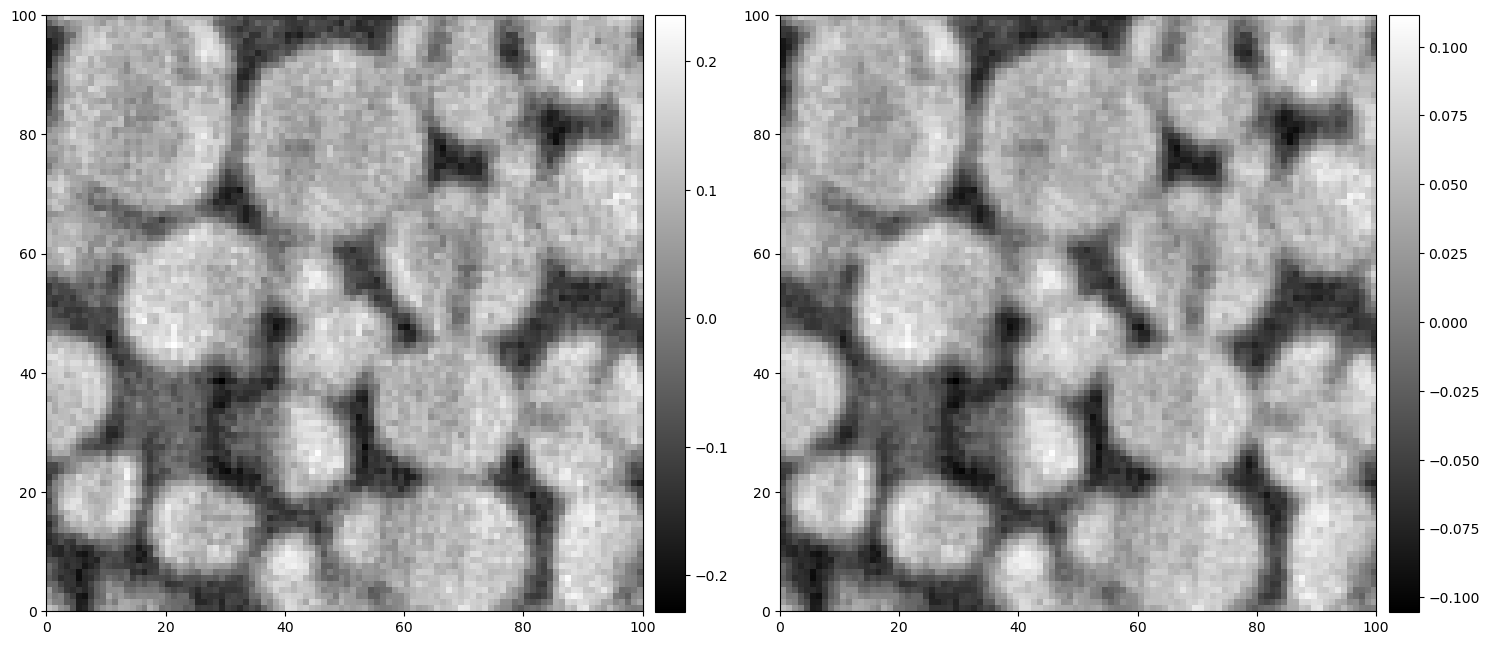

In [21]:
reco = FBP(data_slice).run(verbose=False)
reco.apply_circular_mask(0.9)

show2D([reco_before.array[1000:1100,1000:1100], reco.array[1000:1100,1000:1100]])

Plot a cross-section through the reconstruction

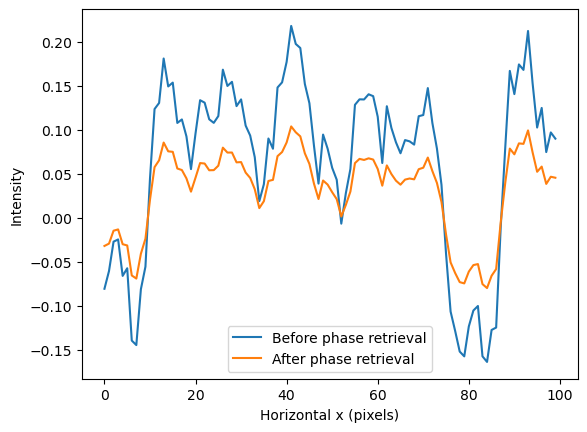

In [22]:
plt.plot(reco_before.array[1100,1100:1200])
plt.plot(reco.array[1100,1100:1200])
plt.xlabel('Horizontal x (pixels)')
plt.ylabel('Intensity')
plt.legend(['Before phase retrieval','After phase retrieval'])

##### Weight duplicate angles

We have some angles with double the data so we see artifacts with FBP reconstruction. We can find the duplicate angles and weight them appropriately for FBP. Using `weight_duplicate_angles` from `weight_duplicate_angles.py`

In [23]:
data_before = data_slice.copy()
reco_before = reco.copy()

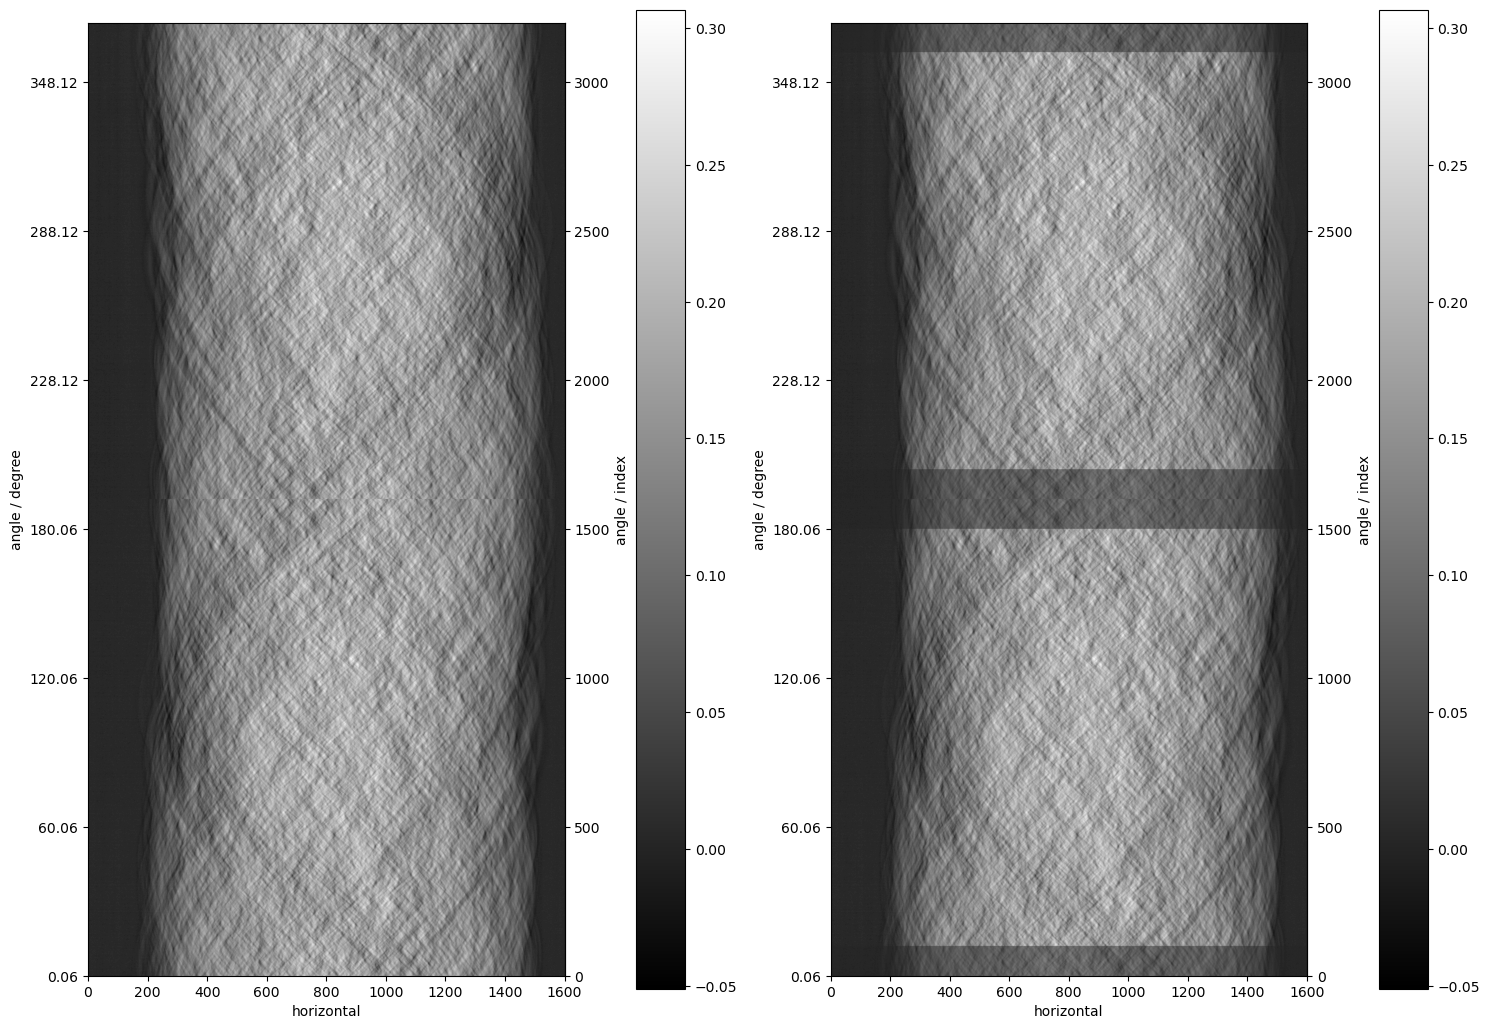

In [24]:
data_slice = WeightDuplicateAngles()(data_slice)

show2D([data_before, data_slice])

And now we reconstruct the corrected data

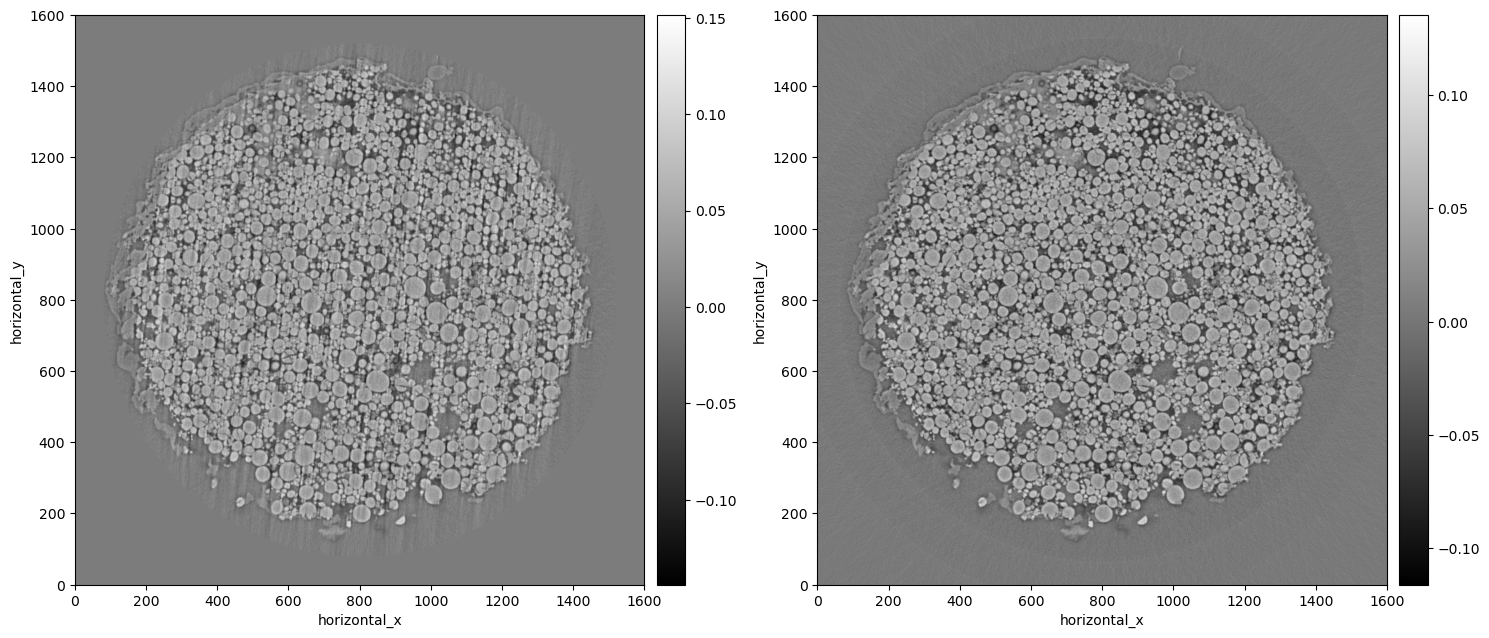

In [25]:
reco = FBP(data_slice).run(verbose=False)

show2D([reco_before, reco])

##### Ring remover

Use the CIL ring remover processor to remove rings using a wavelet decomposition method

- Increasing sigma increases the frequency of ring artefacts that can be removed
- Increasing the number of decompositions  will increase the strength of the ring remover, but too high sigma will distort the profile of the image

In [26]:
data_before = data_slice.copy()
reco_before = reco.copy()

As above, we can loop through different parameters and view the reconstructions with islicer

In [27]:
array_list = []
array_list.append(reco_before.array)
decNum_list = [1, 10, 50, 100, 500]
for d in decNum_list:
    data_slice = RingRemover(decNum = d, wname = "db35", sigma = 1.5,  info = True)(data_before)
    reco = FBP(data_slice).run(verbose=False)
    array_list.append(reco.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Ring remover decNum']) + reco.geometry.dimension_labels)


Finish Ring Remover
Finish Ring Remover
Finish Ring Remover
Finish Ring Remover


/home/bgb37495/miniconda3/envs/cil_esrf/lib/python3.12/site-packages/cil/processors/RingRemover.py:185: RuntimeWarning: invalid value encountered in multiply
  fCv *= damp.T


Finish Ring Remover


There's a ring visible at (700-1100, 700-1100). Cycle through the slices to see how well it is removed

In [28]:
islicer(DC, slice_number=0)


Try the algotom ring remover. 
- Here we are looping over the SNR parameter which defines the noise level below which ring artefats will be ignored. 
- Increasing SNR will reduce the filter strength
- Try other parameters if necessary

In [29]:
array_list = []
array_list.append(reco_before.array)
snr_list = [50, 10, 5, 3, 1]
for s in snr_list:
    data_slice = rem.remove_all_stripe(data_before.as_array(), s, 5, 1)
    data_slice = AcquisitionData(data_slice.astype(np.float32), geometry=data_before.geometry)
    reco = FBP(data_slice).run(verbose=False)
    array_list.append(reco.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Ring remover SNR']) + reco.geometry.dimension_labels)


In [30]:
islicer(DC, slice_number=0)

Choose the preferred ring removal method and apply it to the data 

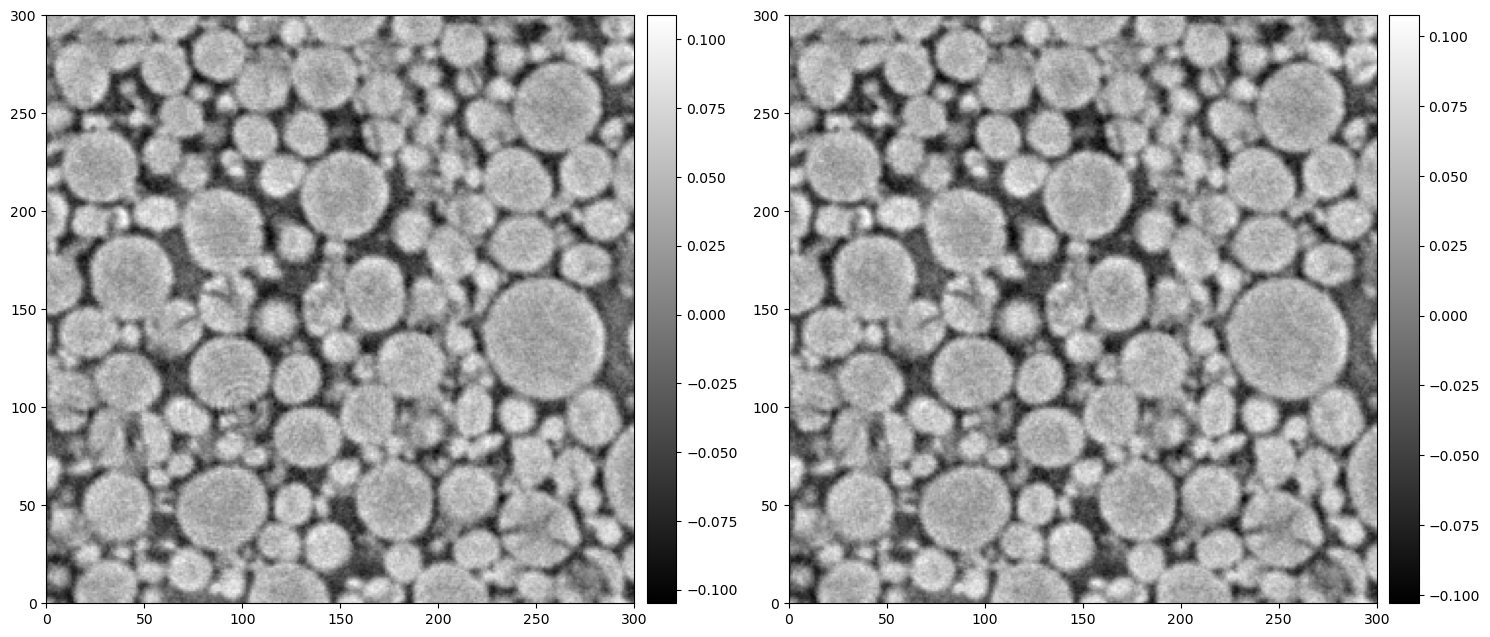

In [31]:
best_snr = 5
data_slice = rem.remove_all_stripe(data_before.as_array(), best_snr, 5, 1)
data_slice = AcquisitionData(data_slice.astype(np.float32), geometry=data_before.geometry)
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before.array[700:1000,700:1000], reco.array[700:1000,700:1000]])

##### Unsharp mask

We do not have an unsharp mask in CIL so we use the implementation in Nabu.

In [32]:
data_before = data_slice.copy()
reco_before = reco.copy()

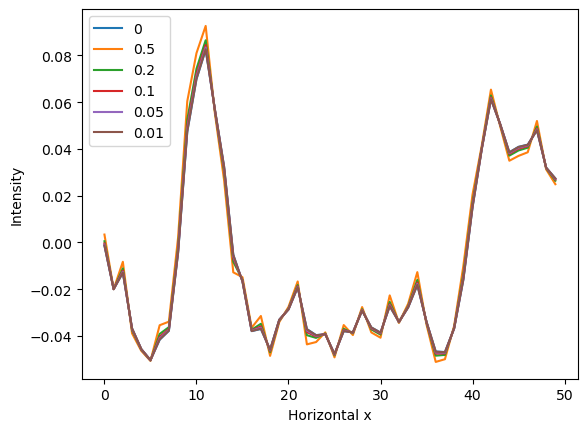

In [33]:
plt.plot(reco_before.array[500,1100:1150])

coeff_list = [0.5, 0.2, 0.1, 0.05, 0.01]
for c in coeff_list:
    mask = UnsharpMask(shape=data_before.shape, sigma=0.1, coeff=c)
    data_slice.fill(mask.unsharp(data_before.array))
    reco = FBP(data_slice).run(verbose=False)
    plt.plot(reco.array[500,1100:1150])

plt.xlabel('Horizontal x')
plt.ylabel('Intensity')
coeff_list.insert(0, 0)
plt.legend(coeff_list)


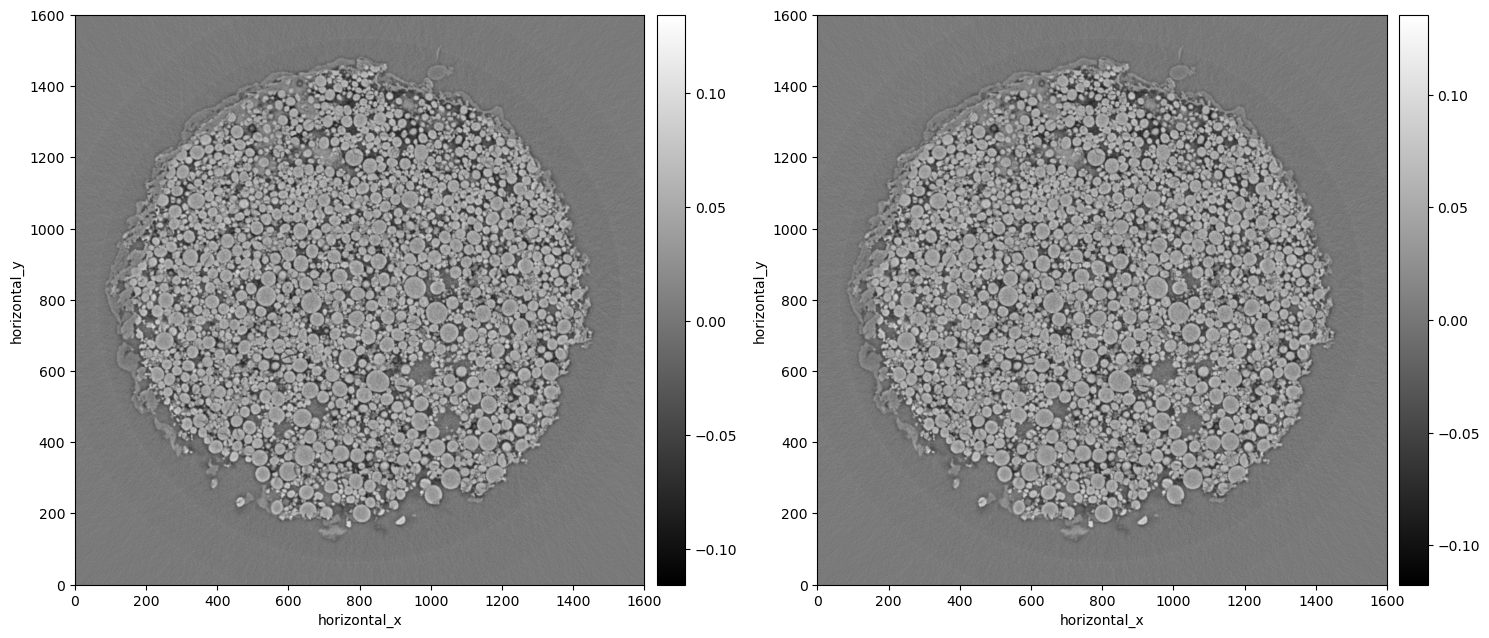

In [34]:
best_coeff = 2
mask = UnsharpMask(shape=data_before.shape, sigma=0.1, coeff=0.1)
data_slice.fill(mask.unsharp(data_before.array))
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before, reco])

##### The final reconstruction

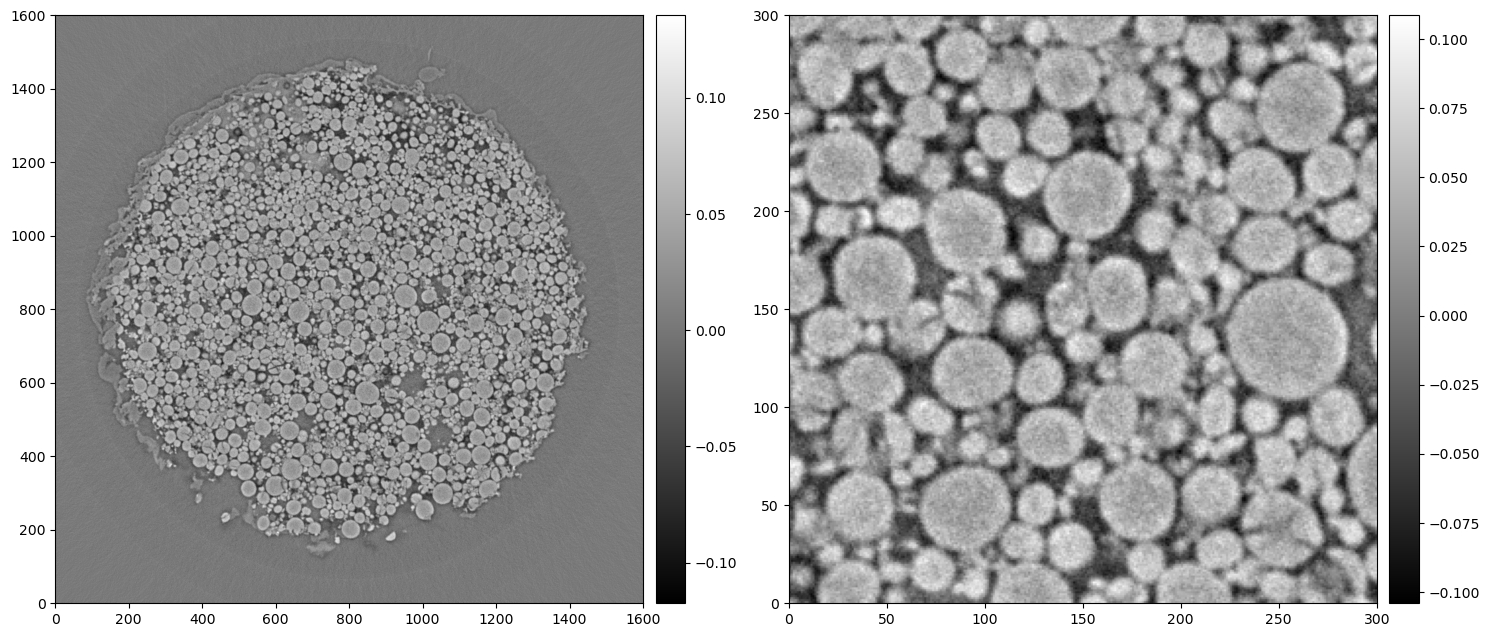

In [37]:
show2D([reco.array, reco.array[700:1000,700:1000]])

##### Save the processed data

Once we're happy with the reconstruction save the processed data as TIFF

In [36]:
writer = TIFFWriter()
writer.set_up(data = data_slice, file_name='path_to_data/data.tiff') #add data type, cast to float16
# writer.write()